In [12]:
import numpy as np
import matplotlib.pyplot as plot
from functools import reduce
import operator
import math

class Vertex:
    position = np.array(2, float)
    name = ""

    def __init__(self, name_ = "", position_ = np.array([0.0,0.0])):
        self.position = position_
        self.name = name_

class Edge:
    vertices = np.array(2, Vertex)
    capacity = 0.0
    length = 0.0
    bi_directional = 0
    name = ""
    flow = 0.0

    def __init__(self, name_ = "", start = Vertex(), end = Vertex(), capacity_ = 0.0, length_ = 0.0, bi_directional_ = 0):
        self.vertices = [start, end]
        self.capacity = capacity_
        self.length = length_
        self.name = name_
        
        assert bi_directional_ in [0,1]
        self.bi_directional = bi_directional_

    def latency(self, flow_change = 0.0):
        if self.capacity>0:
            return (self.flow + flow_change)/self.capacity + self.length
        else:
            return self.length

    def start(self):
        return self.vertices[0]

    def end(self):
        return self.vertices[1]
        
class Path:
    edge_names: np.array
    travelers: int
    start: str
    destination: str

    def __init__(self, start_:str, destination_: str, array=[], travelers_ = 0):
        self.edge_names=array
        self.travelers=travelers_
        self.start=start_
        self.destination=destination_
            
        
        
#This is basically a wheighted graph with directions.
#It tracks the intersections and streets, as well as how many drivers are taking which street.
#It also tracks the latency functions, telling us how long it takes to to travel a street given the amount of drivers on it
class Graph:
    vertices = np.array([], Vertex)
    edges = np.array([], Edge)
    
    def __init__(self):
        self.vertices = []
        self.edges = []

    #several methods to find and add intersections and streets
    def findVert(self, name = ""):
        mask = [vert.name==name for vert in self.vertices]
        
        foundVert = self.vertices[mask]
        assert len(foundVert) == 1
        for vert in foundVert:
            return vert
            
    def findVertIndex(self, name = ""):
        mask = [vert.name==name for vert in self.vertices]
        
        foundVert = self.vertices[mask]
        assert len(foundVert) == 1
        for vertInd in range(len(self.vertices)):
            if self.vertices[vertInd].name==name:
                return vertInd
            
    def addVert(self, name = '', position = np.array([0.0,0.0])):
        newVert = Vertex(name, position)
        
        #if len(self.vertices[self.vertices.position==newVert.position or self.vertices.name==name]) == 0: #wir erlauben bei kreuzungen keine gleichen namen und keine gleichen positionen
        #if len(self.vertices[self.vertices==newVert]) == 0: #wir erlauben bei kreuzungen keine gleichen namen und keine gleichen positionen
        self.vertices = np.append(self.vertices, newVert)

    def findEdgeByStart(self, start = Vertex()):
        mask = [((edge.start().name==start.name) or (edge.bi_directional==1 and edge.end().name==start.name)) for edge in self.edges]
        
        foundEdges = self.edges[mask]
        #assert len(foundEdges) > 0
        return foundEdges

    def findEdge(self, name = ""):
        mask = [(edge.name==name) for edge in self.edges]
        foundEdges = self.edges[mask]
        assert len(foundEdges) > 0
        for edge in foundEdges:
            return edge

    def findEdgeIndex(self, name = ""):
        mask = [(edge.name==name) for edge in self.edges]
        foundEdges = self.edges[mask]
        assert len(foundEdges) > 0
        for edgeInd in range(len(mask)):
            if mask[edgeInd]:
                return edgeInd
    
    def addEdge(self, name = "", start = Vertex(), end = Vertex(), capacity = 0.0, length = 0.0, bi_directional = 0):
        newEdge =  Edge(name, start, end, capacity, length, bi_directional)
        #if len(edges[edges.name==newEdge.name and ((edges.start==start and edges.end==end) or (edges.bi_directional==1 and edges.start==end and edges.end==start))]) == 0: #wir erlauben nur keine gleichen namen zwichen zwei gelichen vertecees
        #if len(edges[edges==newEdge]) == 0:
        self.edges = np.append(self.edges, newEdge)

    #print function to display graph
    def printGraph(self):
        for edge in self.edges:
            x = [edge.start().position[0], edge.end().position[0]]
            y = [edge.start().position[1], edge.end().position[1]]
            plot.plot(x, y)
            
        for vert in self.vertices:
            plot.scatter(vert.position[0], vert.position[1])
            plot.annotate(text=vert.name, xy=(vert.position[0]+0.01, vert.position[1]))

    #changes the amount of drivers on all treets in "path" acording to flow_change
    #"flow_change=0" does nothing
    def updateEdges(self, path: Path, flow_change = 0.0):
        for edge_name in path.edge_names:
            self.edges[self.findEdgeIndex(edge_name)].flow += flow_change
            assert self.edges[self.findEdgeIndex(edge_name)].flow >= 0

    #adds up all the latencies on the streets in "path" taking into acount how many drivers are using these streets
    def compute_latency_along(self, path: Path, flow_change = 0.0):
        latency=0.0
        mask = [(edge.name in path.edge_names) for edge in self.edges]
        path_edges = self.edges[mask]
        for edge in path_edges:
            latency += edge.latency(flow_change=flow_change)
        return latency

#finds the quickest route frome a start vertex to an end vertex taking into acount the currect distribution of drivers in the street network
def dijkstraSearch(streetNetwork: Graph, start_: str, destination_: str):
    start = streetNetwork.findVert(name=start_)
    destination = streetNetwork.findVert(name=destination_)

    
    startInd=streetNetwork.findVertIndex(start.name)
    #saves the quickest time the algorithm has found to any vertex
    latencies = np.full(shape=len(streetNetwork.vertices), fill_value=-1, dtype=float)
    latencies[startInd]=0
    #saves from wich vertex you traveled to any specific vertex, if you take the quickest found path to it
    previous = np.full(shape=len(streetNetwork.vertices),fill_value=-1, dtype=int)
    #safes to wich vertexes we have already found the for sure quickest path
    explored = np.full(shape=len(streetNetwork.vertices),fill_value=0, dtype=bool)
    explored[startInd]=1

    #as long as we have not yet found the quickest path to our destination
    #we keep exploring
    while not explored[streetNetwork.findVertIndex(destination.name)]:
        nearestUnexploredInd=startInd
        for vertInd in range(len(streetNetwork.vertices)):
            if not explored[vertInd]:
                #extra case for setting first 
                if (nearestUnexploredInd == startInd) and (not latencies[vertInd] == -1):
                    nearestUnexploredInd = vertInd
                if (not latencies[vertInd] == -1) and (latencies[vertInd]<=latencies[nearestUnexploredInd]):
                    nearestUnexploredInd = vertInd
        explored[nearestUnexploredInd] = True
    
        #update latencies on vertices next to newly explored vertex
        connectingEdges = streetNetwork.findEdgeByStart(start=streetNetwork.vertices[nearestUnexploredInd])
        for edge in connectingEdges:
            endInd: int
            if edge.start().name==streetNetwork.vertices[nearestUnexploredInd].name:
                endInd=streetNetwork.findVertIndex(edge.end().name)
            if edge.end().name==streetNetwork.vertices[nearestUnexploredInd].name:
                endInd=streetNetwork.findVertIndex(edge.start().name)
            if (latencies[nearestUnexploredInd] + edge.latency(0) < latencies[endInd]) or (latencies[endInd]==-1):
                latencies[endInd] = latencies[nearestUnexploredInd] + edge.latency(0)
                previous[endInd]=streetNetwork.findEdgeIndex(name=edge.name)

    #after we reached our destination
    #regain quickest path from previous array
    startOfRouteInd = streetNetwork.findVertIndex(destination.name)
    route = np.array([], dtype=int)
    while not previous[startOfRouteInd]==-1:
        previousEdge = streetNetwork.edges[previous[startOfRouteInd]]
        route = np.append(route, [previousEdge.name])
        if previousEdge.end().name == streetNetwork.vertices[startOfRouteInd].name:
            startOfRouteInd = streetNetwork.findVertIndex(previousEdge.start().name)
        else:
            startOfRouteInd = streetNetwork.findVertIndex(previousEdge.end().name)

    #return quickest path
    return Path(array = route[::-1], start_ = start.name, destination_= destination.name)

#safes how many drivers are trying to get from "start" to "destination"
#also safes how many are taking wich paths to do so in "trips"
class Demand:
    streetNetwork: Graph
    travelers: int
    start: str
    destination: str

    trips= np.array([], Path)

    def __init__(self, streetNetwork_: Graph, start_: str, destination_: str, travelers_: int):
        self.streetNetwork=streetNetwork_
        self.start=start_
        self.destination=destination_
        self.travelers=travelers_
        self.trips = np.array([], Path)

        self.add_flow_to_path(new_trip=dijkstraSearch(streetNetwork=streetNetwork_, start_=start_, destination_=destination_), flow_change=travelers_)


    # löscht nicht automatisch ungenutzte pfade
    def add_flow_to_path(self, new_trip: Path, flow_change = 0.0):
        assert new_trip.start == self.start and new_trip.destination == self.destination
        
        # check if path allready in use
        mask = [(len(trip.edge_names)==len(new_trip.edge_names)) for trip in self.trips]
        for used_trip in self.trips[mask]:
            #if so add the flow_change to the existing path
            if (np.all(used_trip.edge_names == new_trip.edge_names)):
                used_trip.travelers += flow_change
                self.streetNetwork.updateEdges(used_trip, flow_change=flow_change)
                return

        #if path not allready in use add new path with flow_change as number of travelers
        assert new_trip.travelers==0
        new_trip.travelers=flow_change
        self.streetNetwork.updateEdges(new_trip, flow_change=flow_change)
        self.trips=np.append(self.trips, new_trip)

    #prints flow values to all the streets used by all the paths of this demand
    def printDemand(self):
        self.streetNetwork.printGraph()
        for trip in self.trips:
            for edge_name in trip.edge_names:
                edge = self.streetNetwork.edges[self.streetNetwork.findEdgeIndex(edge_name)]
                plot.annotate(text=[edge.flow, round(edge.latency(), 2)], xy=((edge.start().position[0] + edge.end().position[0]) * 0.5, (edge.start().position[1] + edge.end().position[1]) * 0.5))

    #also print the latency values of all the used paths of this demand
    def printLatencies(self):
        print("-------------------------------------------------")
        print(self.start + "->" + self.destination)
        print("-------------------------------------------------")
        
        tot_latency=0.0
        in_use = [(trip.travelers > 0) for trip in self.trips]
        for trip in self.trips[in_use]:
            print("Trip along ")
            print(trip.edge_names)
            print("Costs ")
            print(self.streetNetwork.compute_latency_along(trip))
            print("Is taken by ")
            print(trip.travelers)
            print("Total cost: ")
            print(trip.travelers * self.streetNetwork.compute_latency_along(trip))
            tot_latency += trip.travelers * self.streetNetwork.compute_latency_along(trip)
            print("-------------------------------------------------")
        return tot_latency

#return how many drivers have to change from "transfer_from_path" to "quicker_path" till both paths take the same time
def distribute_flow_for_equilibrium(streetNetwork: Graph, quicker_path: Path, transfer_from_path):
    #check if we actually have different paths
    if(len(quicker_path.edge_names)==len(transfer_from_path.edge_names)):
        if(np.all(quicker_path.edge_names==transfer_from_path.edge_names)):
                return 0

    #calculate some intermidiate values for formulars
    #assert streetNetwork.compute_latency_along(path=quicker_path) <= streetNetwork.compute_latency_along(path=transfer_from_path)
    mask_quick = [(edge.name in quicker_path.edge_names and edge.capacity > 0) for edge in streetNetwork.edges]
    mask_transfer_from = [(edge.name in transfer_from_path.edge_names and edge.capacity > 0) for edge in streetNetwork.edges]
    capacity_sum_quick=0.0
    capacity_sum_transfer_from=0.0
    for edge in streetNetwork.edges[mask_quick]:
        capacity_sum_quick += 1/edge.capacity
    for edge in streetNetwork.edges[mask_transfer_from]:
        capacity_sum_transfer_from += 1/edge.capacity

    #calculate flow_change necessary to equalize latency
    flow_change = (streetNetwork.compute_latency_along(path=transfer_from_path) - streetNetwork.compute_latency_along(path=quicker_path)) / (capacity_sum_quick + capacity_sum_transfer_from)
    flow_change = math.floor(min([flow_change, transfer_from_path.travelers]))
    return flow_change

#takes in the streetnetworks and demands, to find the Nash Equilibrium
def compute_equilibrium(streetNetwork: Graph, demands: np.array):
    is_in_equilibrium = False
    while not is_in_equilibrium:
        is_in_equilibrium = True
        for dem in demands:
            quickest_path = dijkstraSearch(streetNetwork=streetNetwork, start_=dem.start, destination_=dem.destination)

            for trip in dem.trips:
                flow_change = distribute_flow_for_equilibrium(streetNetwork=streetNetwork, quicker_path=quickest_path, transfer_from_path=trip)
                if flow_change > 0:
                    is_in_equilibrium = False
                dem.add_flow_to_path(new_trip=trip, flow_change=-flow_change)
                dem.add_flow_to_path(new_trip=quickest_path, flow_change=flow_change)
        

# Mountain Cities
  1
 / \
a   b
 \ /
  2

-------------------------------------------------
a->b
-------------------------------------------------
Trip along 
['a1' '1b']
Costs 
65.0
Is taken by 
2000
Total cost: 
130000.0
-------------------------------------------------
Trip along 
['a2' '2b']
Costs 
65.0
Is taken by 
2000
Total cost: 
130000.0
-------------------------------------------------
Avg. TT:
65.0


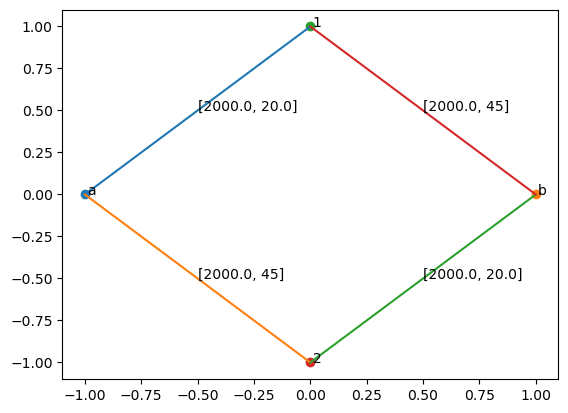

In [24]:
streetNetwork = Graph()

streetNetwork.addVert("a", [-1,0])
streetNetwork.addVert("b", [1,0])
streetNetwork.addVert("1", [0,1])
streetNetwork.addVert("2", [0,-1])
streetNetwork.addEdge(name = "a1", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("1"), capacity=100, length=0, bi_directional=1)
streetNetwork.addEdge(name = "a2", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("2"), capacity=-1, length=45, bi_directional=1)
streetNetwork.addEdge(name = "2b", start = streetNetwork.findVert("2"), end = streetNetwork.findVert("b"), capacity=100, length=0, bi_directional=1)
streetNetwork.addEdge(name = "1b", start = streetNetwork.findVert("1"), end = streetNetwork.findVert("b"), capacity=-1, length=45, bi_directional=1)
#uncomment next line to see difference in Avg. TT.
#streetNetwork.addEdge(name = "12", start = streetNetwork.findVert("1"), end = streetNetwork.findVert("2"), capacity=-1, length=0, bi_directional=1)



demand0=Demand(streetNetwork_=streetNetwork, start_="a", destination_="b", travelers_=4000)
demands = [demand0]

compute_equilibrium(streetNetwork=streetNetwork, demands=demands)

tot_latency=0.0
tot_drivers=0
for dem in demands:
    dem.printDemand()
    tot_latency+=dem.printLatencies()
    tot_drivers+=dem.travelers
print("Avg. TT:")
print(tot_latency/(tot_drivers))

# Bypass Outer City
    c
  / |
a---b

-------------------------------------------------
a->c
-------------------------------------------------
Trip along 
['ab_street' 'bc_street']
Costs 
240.11999999999998
Is taken by 
151
Total cost: 
36258.119999999995
-------------------------------------------------
Trip along 
['ac_bypass']
Costs 
240.0
Is taken by 
49
Total cost: 
11760.0
-------------------------------------------------
-------------------------------------------------
a->b
-------------------------------------------------
Trip along 
['ab_street']
Costs 
12.059999999999999
Is taken by 
50
Total cost: 
602.9999999999999
-------------------------------------------------
-------------------------------------------------
b->c
-------------------------------------------------
Trip along 
['bc_street']
Costs 
228.05999999999997
Is taken by 
3650
Total cost: 
832418.9999999999
-------------------------------------------------
Avg. TT:
225.90772307692305


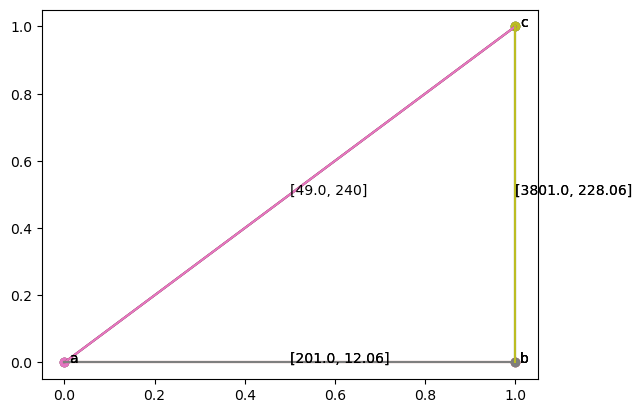

In [33]:
g_ac=200
g_ab=50 #you can also change g_12 to 250 to wittnes braess paradox
g_bc=3650

streetNetwork = Graph()


streetNetwork.addVert("a", [0,0])
streetNetwork.addVert("b", [1,0])
streetNetwork.addVert("c", [1,1])
streetNetwork.addEdge(name = "ac_bypass", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("c"), capacity=-1, length=240, bi_directional=0)
#in the next line change length to 30 ti wittness Braess Paradox
streetNetwork.addEdge(name = "ab_street", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("b"), capacity=100/6, length=0, bi_directional=0)
streetNetwork.addEdge(name = "bc_street", start = streetNetwork.findVert("b"), end = streetNetwork.findVert("c"), capacity=100/6, length=0, bi_directional=0)



demand_13=Demand(streetNetwork_=streetNetwork, start_="a", destination_="c", travelers_=g_ac)
demand_12=Demand(streetNetwork_=streetNetwork, start_="a", destination_="b", travelers_=g_ab)
demand_23=Demand(streetNetwork_=streetNetwork, start_="b", destination_="c", travelers_=g_bc)
demands = [demand_13, demand_12, demand_23]

compute_equilibrium(streetNetwork=streetNetwork, demands=demands)

tot_latency=0.0
tot_drivers=0
for dem in demands:
    dem.printDemand()
    tot_latency+=dem.printLatencies()
    tot_drivers+=dem.travelers
print("Avg. TT:")
print(tot_latency/(tot_drivers))

# Bonus Example
  __
 /  \
|    |
a----b

-------------------------------------------------
a->b
-------------------------------------------------
Trip along 
['abSlow']
Costs 
59.99999999999999
Is taken by 
1000
Total cost: 
59999.99999999999
-------------------------------------------------
Avg. TT:
59.99999999999999


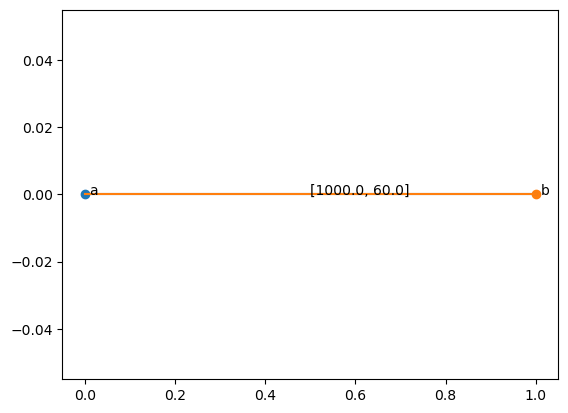

In [25]:
g_ab=1000

streetNetwork = Graph()


streetNetwork.addVert("a", [0,0])
streetNetwork.addVert("b", [1,0])
# play around with the capacity and length, to see that we can't force Braess Paradox
streetNetwork.addEdge(name = "abSlow", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("b"), capacity=1000/60, length=0, bi_directional=0)
streetNetwork.addEdge(name = "abFast", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("b"), capacity=-1, length=60, bi_directional=0)


demand_ab=Demand(streetNetwork_=streetNetwork, start_="a", destination_="b", travelers_=g_ab)
demands=[demand_ab]

compute_equilibrium(streetNetwork=streetNetwork, demands=demands)

tot_latency=0.0
tot_drivers=0
for dem in demands:
    dem.printDemand()
    tot_latency+=dem.printLatencies()
    tot_drivers+=dem.travelers
print("Avg. TT:")
print(tot_latency/(tot_drivers))

# Some familiar setting to experiment with

-------------------------------------------------
a->b
-------------------------------------------------
Trip along 
['ab']
Costs 
105.0
Is taken by 
5
Total cost: 
525.0
-------------------------------------------------
-------------------------------------------------
b->c
-------------------------------------------------
Trip along 
['bc']
Costs 
130.0
Is taken by 
130
Total cost: 
16900.0
-------------------------------------------------
-------------------------------------------------
a->c
-------------------------------------------------
Trip along 
['ac']
Costs 
210.0
Is taken by 
90
Total cost: 
18900.0
-------------------------------------------------
36325.0


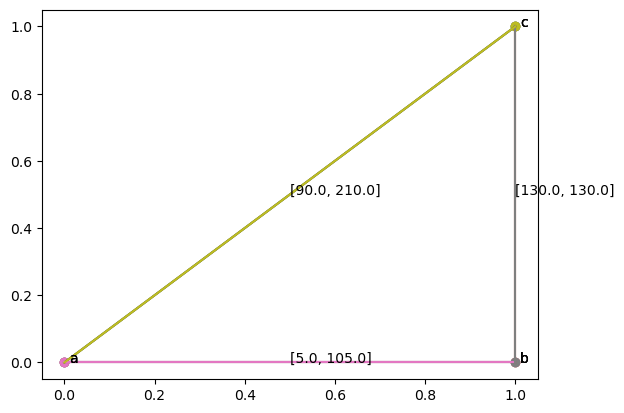

In [13]:
e=100#10-35-...
d=120
g_ac=90
g_ab=5
g_bc=130

streetNetwork = Graph()


streetNetwork.addVert("a", [0,0])
streetNetwork.addVert("b", [1,0])
streetNetwork.addVert("c", [1,1])
streetNetwork.addEdge(name = "ab", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("b"), capacity=1, length=e, bi_directional=0)
streetNetwork.addEdge(name = "bc", start = streetNetwork.findVert("b"), end = streetNetwork.findVert("c"), capacity=1, length=0, bi_directional=0)
streetNetwork.addEdge(name = "ac", start = streetNetwork.findVert("a"), end = streetNetwork.findVert("c"), capacity=1, length=d, bi_directional=0)


demand_ab=Demand(streetNetwork_=streetNetwork, start_="a", destination_="b", travelers_=g_ab)
demand_bc=Demand(streetNetwork_=streetNetwork, start_="b", destination_="c", travelers_=g_bc)
demand_ac=Demand(streetNetwork_=streetNetwork, start_="a", destination_="c", travelers_=g_ac)

compute_equilibrium(streetNetwork=streetNetwork, demands=[demand_ab, demand_bc, demand_ac])

tot_latency=0.0
demand_ab.printDemand()
tot_latency+=demand_ab.printLatencies()
demand_bc.printDemand()
tot_latency+=demand_bc.printLatencies()
demand_ac.printDemand()
tot_latency+=demand_ac.printLatencies()
print(tot_latency)